Python version 3.4.3 |Anaconda 2.3.0 (x86_64)| (default, Mar  6 2015, 12:07:41) 
[GCC 4.2.1 (Apple Inc. build 5577)]





Hi, welcome to SynBioCAD.

by Leo d'Espaux, leodespaux@gmail.com
Here you can design your expression cassette, and get primers to quickly integrate it.
You can delete existing genes, or replace them. You can build expression cassettes using
standardized well-characterized parts. You can view data on parts performance at different
cell states, media, time points, using open-source, transparent, NIST-calibrated data.
You can add protein tags to control protein parameters, e.g. degradation rate, solubility,
or sub-cellular localization. And hopefully, it'll be easy, and it will work. 

Refer to this community google doc for documentation and feedback:
https://docs.google.com/document/d/11YNoUBtit4rkWZQr_ZclzAOTE_HGMtgB3H_6cvq1Y24/edit?usp=sharing




WHAT DO YOU WANT TO DO TO S288C? Type "1" or "2".

	 1 	 Insert an expression cassette into an empty, well-characterized

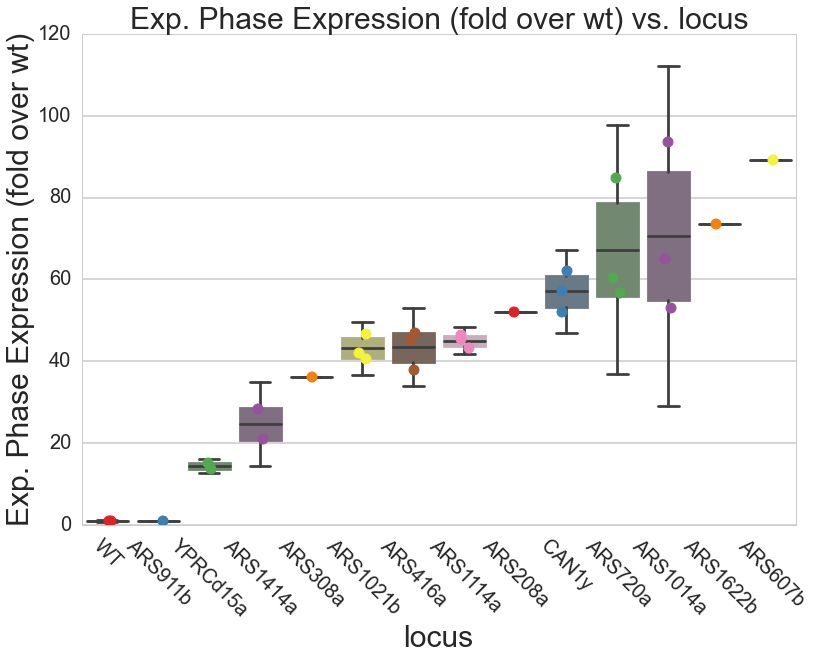

          cutChr           cutSequence
cutName                               
ARS106a   Scer01  ATACGGTCAGGGTAGCGCCC
ARS208a   Scer02  GTCCGCTAAACAAAAGATCT
ARS208b   Scer02  TAGGATACAAGTGTCTGTGC
ARS308a   Scer03  CACTTGTCAAACAGAATATA
LEU2a     Scer03  AAAGGTGAGAGCGCCGGAAC
MATαa     Scer03  GCCCTGGATAGCGAAGCGTG
MATαb     Scer03  AATGATGTCTGGGTTTTGTT
MATαc     Scer03  TGGGAACAAGAGCAAGACGA
RDS1a     Scer03  ATTCAATACGAAATGTGTGC
ARS416a   Scer04  CCTTCAAAGGATTCACCAGA
ARS416b   Scer04  TTAGGGACAGTTAGAGGCGG
ARS416c   Scer04  CAATTCAGGCCAAATCTTGA
ARS416d   Scer04  TAGTGCACTTACCCCACGTT
ARS511b   Scer05  CAGTGTATGCCAGTCAGCCA
URA3a     Scer05  ATTCGCTATTATTCAAGCTT
URA3b     Scer05  CCTTCGTTCTTCCTTCTGCT
CAN1y     Scer05  GATACGTTCTCTATGGAGGA
ARS607b   Scer06  CCAGCGTAAGGTAAATATTA
ARS607c   Scer06  CTATTTTTGCTTTCTGCACA
SAP155b   Scer06  GGTTTTCATACTGGGGCCGC
SAP155c   Scer06  ATGAAAGACAACTATAGGGC
ARS720a   Scer07  CAACAATTGTTACAATAGTA
ARS720b   Scer07  TTTCTTAGCCTAAGCTAGGC
ARS805a   Scer08  TTATTTG

In [ ]:
'''
SynBioCAD
by Leo d'Espaux 
leodespaux@gmail.com

Help by: William Zhuang

Current as of 1/12/2016

Recent updates:
*Added figures with current locus and promoter level
*Added info on user guide
*Added image of CNE1 tag, to expand on later
'''


# import libraries we're using

from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from Bio.SeqUtils import MeltingTemp
import copy
from intermine.webservice import Service
from pandas import *
from pandas import DataFrame, read_csv
import pandas as pd  
import matplotlib.pyplot as plt
import sys
from IPython.display import Image
from IPython.display import display
%matplotlib inline 



# define global variables
HomologyLength = 1000
PrimerMaxTm = 55 # As calculated by statluc, more like 65C by Thermo's Phusion program
PrimerMaxLen = 60
OverhangMaxFrac = 1



def askUser():
    print('Python version ' + sys.version+"\n\n\n\n")
    print("\nHi, welcome to SynBioCAD.\n")
    print("Here you can design your expression cassette, and get primers to quickly integrate it.")
    print("You can delete existing genes, or replace them. You can build expression cassettes using")
    print("standardized well-characterized parts. You can view data on parts performance at different")
    print("cell states, media, time points, using open-source, transparent, NIST-calibrated data.")
    print("You can add protein tags to control protein parameters, e.g. degradation rate, solubility,")
    print("or sub-cellular localization. And hopefully, it'll be easy, and it will work. \n")
          
    print("Refer to this community google doc for documentation and feedback:")
    print("https://docs.google.com/document/d/11YNoUBtit4rkWZQr_ZclzAOTE_HGMtgB3H_6cvq1Y24/edit?usp=sharing")
    print("\n\n\n\nWHAT DO YOU WANT TO DO TO S288C? Type \"1\" or \"2\".\n")
    print("\t 1 \t Insert an expression cassette into an empty, well-characterized site\n") 
    print("\t 2 \t Delete existing gene, or replace it with something else\n")
    #print("\t 3 \t get primers to stitch together linear DNA fragments \(not nec\n")

   
    Action= input("Your answer: ")
    if Action == "1":
        editEmpty()
        
    elif Action == "2":
        editExisting()

    elif Action == "3": # This is more for stitching things together not necessarily for CRISPR
        buildCustom()
             
            
            
def editEmpty():    
    
    # I have an excel file where we keep cut site information
    # and load it as a pandas dataframe called cutFrame
    
    cutFrame = pd.read_excel("locusTable.xlsx", index_col="cutName")
    
    print("\nWe've built plasmids for integration into a few empty sites.")
    print("These follow a standardized integration framework, see manual.")
    
    LocusPic=Image("LocusLevelExp.png")
    display(LocusPic)
 
    print(cutFrame)
         
    print("We've built plasmids for integration into a few empty sites, following")
    print("a standardized integration framework, see manual. Above is data on the sites we have.")
    print("\n\n\n\nWHICH CUT SITE DO YOU WANT from the above list? e.g., \"ARS208a\"")
    cutName=input("Your answer: ")

    # cutName is a string that should correspond to one of the variables
    # of the "cutName" column in dataFrame, e.g., ARS208a
    
    # cutFrame has the 20nt sequence of the gRNA saved, which we load
    # It also has some more information we'll get to later
    cutSequence=cutFrame.loc[cutName,'cutSequence']

    # We need to load the chromosome where the cut site is
    location=cutFrame.loc[cutName,'cutChr']+".fasta"
     
    ChromosomeSeq=SeqIO.read(location, "fasta").seq
    
    if ChromosomeSeq.find(cutSequence)==-1:
        ChromosomeSeq=ChromosomeSeq.reverse_complement()
        if ChromosomeSeq.find(cutSequence)==-1:
            print("CAN'T FIND THE CUT SITE IN YOUR SEQUENCE")

    StartIndex=ChromosomeSeq.find(cutSequence)
    EndIndex=StartIndex+34
    
    UpSeq=ChromosomeSeq[StartIndex-HomologyLength:StartIndex]
    DownSeq=ChromosomeSeq[EndIndex:EndIndex+HomologyLength]
        
    UpHomRec = SeqRecord(UpSeq, name="up"+cutName)
    DownHomRec = SeqRecord(DownSeq, name=cutName)
    
    print("\n\n\n\nWhat do you want to do to " + cutName + "?\n"
         )
    print("\t1\t You have a CDS but want help picking promoter and terminator\n")
    print("\t2\t You already have a one-piece cassette and just want to integrate it\n\n")
    # Coming later
    # print("\t3\t You want to construct a donor containing two standard cassettes (pointing away from each other\n")

    typeEdit=input("Your answer: ")
    if typeEdit=="1":
    
        PromoterRec, orfRecord, TerminatorRec = buildCassette()
        
        fragments=[UpHomRec, PromoterRec, orfRecord, TerminatorRec, DownHomRec]

    
    elif typeEdit == "2":
        
        orfName=input("What's the name of your custom gene or cassette?")
        orfSeq=Seq(input("What's the sequence? "))
        orfRecord=SeqRecord(orfSeq,name=orfName)
        
        fragments=[UpHomRec, orfRecord, DownHomRec]

    elif typeEdit == "3":
        
        print("Your construct will look like this: ")
        print("up hom-<terminator1-gene1-promoter1<->promoter2-gene2-terminator2>-downhom")
        print("OK, let's build your FIRST cassette")
        PromoterRec1, orfRecord1, TerminatorRec1 = buildCassette()
         
        #now in the construction, these will be in the antisense direction, so let's change their sequences
        rTerminatorRec1=flipRecord(TerminatorRec1)
        rorfRecord1=flipRecord(orfRecord1)
        rPromoterRec1=flipRecord(PromoterRec1)
        
        print("OK, let's build your SECOND cassette")
        PromoterRec2, orfRecord2, TerminatorRec2 = buildCassette()

        fragments=[UpHomRec, rTerminatorRec1, rorfRecord1, rPromoterRec1,PromoterRec2,orfRecord2, TerminatorRec2,DownHomRec]

    print("\n\n\n\n\n\n\n\n")
    stitch(fragments)
    
    
    
def editExisting():
    
    print(" ")
    print("WHICH GENE DO YOU WANT TO EDIT? Tell me a common name, e.g., \"OAF1\"")
    print("I'm smart and pretty and I can fetch it for you.\n")
    
    GeneName= input("Your answer: ")
    
    OrigGeneRecord=fetchGene(GeneName)
    # note that this returns a seqrecord
    
    print("\n"+GeneName+" is "+OrigGeneRecord.features+", which encodes "+OrigGeneRecord.description+", Bold choice.")

    
    # We make seqrecords since that's what we carry through later in the program

    UpHomRec = fetchNeighbor(OrigGeneRecord, "upstream", HomologyLength )
    UpHomRec.name="up"+UpHomRec.name 
    DownHomRec = fetchNeighbor(OrigGeneRecord, "downstream", HomologyLength )
    DownHomRec.name="down"+DownHomRec.name 

    print("\n\n\n\nWHAT DO YOU WANT TO DO TO " + GeneName + "?\n")
    print("\t1\t DELETE the CDS cleanly--from start to stop codon\n")
    print("\t2\t replace the CDS with another CDS\n")
    print("\t3\t replace the CDS with an expression cassette I will help you build\n")
    #print("\t4\t replace the CDS with a custom cassette (soon)")
    #print("\t5\t replace a specified region near your target gene (soon)")
    
    typeEdit=input("Your answer: ")
    
    # Now let's pick the cut site. This is independent from the donor cassette
    # We have an excel sheet with genes and pre-picked cut sites
    # Or let the user pick
    
    print("\nHave you heard of CRISPR? We will need a guideRNA. In the future I will help you pick it.")
    print("For now, please enter your 20-nt gRNA here.\n")
    
    
    cutChoice=input("Your answer: ")
    
    if cutChoice=="p":
        cutSequence=cutFinder(GeneName)
    elif len(cutChoice)==20:
        cutSequence=cutChoice
        # Later should check that the sequence is present and unique
    
   
    
    #note that in all the below, we want to have fragments be records
    if typeEdit=="1":
        fragments=[UpHomRec,DownHomRec]
    
    if typeEdit=="3":
        PromoterRec, orfRecord, TerminatorRec = buildCassette()
        fragments=[UpHomRec, PromoterRec, orfRecord, TerminatorRec, DownHomRec] #we need to finish buildcassette to add InsertRec here

    if typeEdit=="2":
        print(" ")
        NewGeneName=input("\n\n\n\nWhat's the name of the gene you're inserting?")
        NewGeneSeq=Seq(input("\n\n\n\nWhat's the sequence of your new gene? "))
        InsertRec = SeqRecord(NewGeneSeq, name=NewGeneName)
        fragments=[UpHomRec, InsertRec, DownHomRec]

    if typeEdit=="4":
        print("How many pieces (other than homology fragments) are you stitching together.")
        Npieces=input("Your answer: ")
        output = buildCassette()

        fragments=[UpHomRec, DownHomRec] #we need to finish buildcassette to add InsertRec here

    
    print("\n\n\n\n\n\n\n\nHere is the oligo to clone or gap-repair your cut plasmid:\n")
    print("cut"+GeneName+" tggcgaatgggacttt"+cutSequence+"gttttagagctagaaatagcaagt\n")

    # Now we feed the design to a tool to pick primers which amplify each fragment
    # and add terminal homology to the neighboring fragments
    
    
    stitch(fragments)

    
    
def buildCustom():
    N = int(input("How many pieces in your custom cassette: "))
    fragments = variableCassette(N)[0]
    stitch(fragments)

            
    #------------------------------ FETCH FUNCTIONS -------------------------------------

    
def fetchGene(GeneName):
    
    service = Service("http://yeastmine.yeastgenome.org/yeastmine/service")
    template = service.get_template('Gene_GenomicDNA')

    rows = template.rows(
        E = {"op": "LOOKUP", "value": GeneName, "extra_value": "S. cerevisiae"}
    )
    
    # this service seems to return multiple similar genes but we want the first one only, so count
    # and it returns information about the gene you want
    count=0
    for row in rows:
        
        count=count+1
        if count==1:
            descr= row["description"]
            GeneSeq=Seq(row["sequence.residues"])
            GeneSysName=row["secondaryIdentifier"]
       
    #let's create a record for the oldGene
    GeneRecord = SeqRecord(GeneSeq, id=GeneSysName)
    
    #now let's add some more information to make it useful
    GeneRecord.name=GeneName
    GeneRecord.features=GeneSysName
    GeneRecord.description=descr

    return GeneRecord 
       
    
    
def fetchNeighbor(NeighborRecord, direction, distance):

    # let's load the appropriate chromosome file. The record of the gene we looked up
    # contains in the "features" the systematic name, wherein the second letter
    # corresponds to chromosome number, e.g., 1=A etc
    if NeighborRecord.features[1]=="A":
        ChromosomeRec=SeqIO.read("Scer01.fasta", "fasta")
    if NeighborRecord.features[1]=="B":
        ChromosomeRec=SeqIO.read("Scer02.fasta", "fasta")
    if NeighborRecord.features[1]=="C":
        ChromosomeRec=SeqIO.read("Scer03.fasta", "fasta")
    if NeighborRecord.features[1]=="D":
        ChromosomeRec=SeqIO.read("Scer04.fasta", "fasta")
    if NeighborRecord.features[1]=="E":
        ChromosomeRec=SeqIO.read("Scer05.fasta", "fasta")
    if NeighborRecord.features[1]=="F":
        ChromosomeRec=SeqIO.read("Scer06.fasta", "fasta")
    if NeighborRecord.features[1]=="G":
        ChromosomeRec=SeqIO.read("Scer07.fasta", "fasta")
    if NeighborRecord.features[1]=="H":
        ChromosomeRec=SeqIO.read("Scer08.fasta", "fasta")
    if NeighborRecord.features[1]=="I":
        ChromosomeRec=SeqIO.read("Scer09.fasta", "fasta")
    if NeighborRecord.features[1]=="J":
        ChromosomeRec=SeqIO.read("Scer10.fasta", "fasta")
    if NeighborRecord.features[1]=="K":
        ChromosomeRec=SeqIO.read("Scer11.fasta", "fasta")
    if NeighborRecord.features[1]=="L":
        ChromosomeRec=SeqIO.read("Scer12.fasta", "fasta")
    if NeighborRecord.features[1]=="M":
        ChromosomeRec=SeqIO.read("Scer13.fasta", "fasta")
    if NeighborRecord.features[1]=="N":
        ChromosomeRec=SeqIO.read("Scer14.fasta", "fasta")
    if NeighborRecord.features[1]=="O":
        ChromosomeRec=SeqIO.read("Scer15.fasta", "fasta")
    if NeighborRecord.features[1]=="P":
        ChromosomeRec=SeqIO.read("Scer16.fasta", "fasta") 

    
    
    # let's explicitely name the sequences from the seq record
    NeighborSeq=NeighborRecord.seq
    ChromosomeSeq=ChromosomeRec.seq
    
    # flip the sequence to orient with respect to the old gene
    if ChromosomeSeq.find(NeighborSeq)==-1:
        ChromosomeSeq=ChromosomeSeq.reverse_complement()

    StartIndex=ChromosomeSeq.find(NeighborSeq)
    EndIndex=StartIndex+len(NeighborSeq)
    
    if direction=="upstream":
        DesiredSeq=ChromosomeSeq[StartIndex-distance:StartIndex]
    if direction=="downstream":
        DesiredSeq=ChromosomeSeq[EndIndex:EndIndex+distance]

    
    
    
    NeighborRec = SeqRecord(DesiredSeq, name=NeighborRecord.name)
    
    return NeighborRec


    
    
    
    #------------------------------------ CONSTRUCTING STUFF --------------------------------------

def getPrimer(currRecord):
    

    mp = 0
    length = 0
    primer = Seq("")

    seq=currRecord.seq
    
    while mp <= PrimerMaxTm and length <= PrimerMaxLen:
        primer = primer + seq[length]
        mp = MeltingTemp.Tm_staluc(primer)
        length += 1

    return primer           
        
def overhangPrimer(currRecord,prevSeq):
    #let's get the template-binding primer first
    primer=getPrimer(currRecord)
    
    
    #OK let's work on the overhang
    maxOhLen=PrimerMaxLen-len(primer)    
    maxFrac=1
    
    #let's decide on a max overhang length
    if round(len(primer)*(OverhangMaxFrac+1)) < 60:
             maxOhLen=round(len(primer)*OverhangMaxFrac)
    
    #the index must be an integer!!!
    maxOhLen=int(maxOhLen)
    ohprimer=prevSeq.seq[-maxOhLen:]+primer #we add the .seq so that it returns a string
    
    return ohprimer      
        

          
def buildCassette():
    
    # Let's display data
    PromPic=Image("PromoterLevelExp.png")
    display(PromPic) 
    
    print("\nI'm going to build what we call a \"standard cassette\".")
    print("All our parts are standardized, modular, and well-characterized, to make your life easier.")
    print("The promoters are 600bp long, terminators 250bp. They are immediately adjacent to the start,") 
    print("or stop codon, respectively, of your target gene. But don't worry about the little things.") 
    print("Above are the promoters we have characterized. These data are in YPD with a GFP reporter.") 
    print("See the manual for more information, or data from different conditions, or links to data")
    print("from other labs. I haven't tested terminators yet, see manual for excellent data from other labs.")
    
   
    print("\n\n\n\nWhich PROMOTER do you want to use, e.g., \"TDH3\"")
    
    PromoterName=input("Your answer: ")
    PromoterGeneRec=fetchGene(PromoterName)
    PromoterRec=fetchNeighbor(PromoterGeneRec,"upstream",600)
    PromoterRec.name=PromoterRec.name+"ps"
    
    
    #second, the terminator
    print("\n\n\n\nWhich TERMINATOR do you want to use, e.g., \"ADH1\"")
    TerminatorName = input('Your answer: ')
    TerminatorGeneRec=fetchGene(TerminatorName)
    TerminatorRec=fetchNeighbor(TerminatorGeneRec,"downstream",250)
    TerminatorRec.name=TerminatorRec.name+"ts"
    
    #and last, the gene
    print("\n\n\n\nWhat is the name of your CDS, e.g., \"KlGapDH\"")
    orfName = input("Your answer: ")
    
    print("\n\n\n\nWhat's the sequence")
    orfSeq=input("Your answer: ")
    
    orfRecord=SeqRecord(Seq(orfSeq), name=orfName)
    
    #print("\nDo you want to attach any protein tags?\n")
    #print("This is under construction but here is tag CNE1 targeting to the ER lumen.\n")
    #CNE1tag=Image("CNE1tag.png")
    #display(CNE1tag)
    
    insertRec=[PromoterRec,orfRecord,TerminatorRec]
    return PromoterRec, orfRecord, TerminatorRec
    


def stitch(fragments):
    #this function takes seq records and prints primers
    
    #let's make an empty sequence file
    Nfrags=len(fragments)
    donor=Seq("")
    index=[]

    print("\n\n\n\nHere are the primers to amplify your fragments and construct your donor DNA cassette:\n")

    for i in range (0, Nfrags):
        donor=donor+fragments[i]
    
    # The names include information on the homology provided by the overhang
    # Note that some primers don't have overhangs
    for i in range (0, Nfrags):
        if i==0:
            print("L"+ fragments[i].name + " " + getPrimer(donor))
            print("R"+ fragments[i].name + "(" + fragments[i+1].name + ") " + overhangPrimer(fragments[i].reverse_complement(),fragments[i+1].reverse_complement()))
        elif i==Nfrags-1:
            print("L"+ fragments[i].name + "(" + fragments[i-1].name + ") " + overhangPrimer(fragments[i],fragments[i-1]))
            print("R"+ fragments[i].name + " " + getPrimer(donor.reverse_complement()))
        else:
            print("L"+ fragments[i].name + "(" + fragments[i-1].name + ") " + overhangPrimer(fragments[i],fragments[i-1]))
            print("R"+ fragments[i].name + "(" + fragments[i+1].name + ") " + overhangPrimer(fragments[i].reverse_complement(),fragments[i+1].reverse_complement()))

    print("\n\nThe size and sequence of your donor DNA is below.")

    print(len(donor.seq))

    print(donor.seq)

    print("\nGOOD LUCK! Refer to the this link for user guide, feedback, and community tips.")
    print("https://docs.google.com/document/d/11YNoUBtit4rkWZQr_ZclzAOTE_HGMtgB3H_6cvq1Y24/edit?usp=sharing\n")
    
        
def flipRecord(origRecord):
    origRecord.seq=origRecord.seq.reverse_complement()
    origRecord.name="r"+origRecord.name
    return origRecord
    
def cutFinder(GeneName):
    cutFrame = pd.read_excel("cutsTable.xlsx", index_col="cutName")
    
    # cutFrame has the 20nt sequence of the gRNA saved, which we load
    # It also has some more information we'll get to later
    
    cutSequence=cutFrame.loc[GeneName,'cutSequence']
    
    print("\nI picked the following cut site for you "+cutSequence)
    
    return cutSequence


askUser()

